In [1]:
import sys
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage as ski
import PIL as PIL
import time
import SimpleITK as sitk
import elasticdeform
import matplotlib.image as mpimg

from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
from scipy.ndimage import sobel
from PIL import Image
from skimage import measure
from skimage.segmentation import random_walker
from skimage import io 
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from mpl_toolkits.mplot3d import Axes3D


np.set_printoptions(threshold = 1000000000)

In [2]:
# Load data and get pixel information

image = sitk.ReadImage(r"test_trus.gipl")

print("origin: " + str(image.GetOrigin()))
print("size: " + str(image.GetSize()))
print('spacing: ' + str(image.GetSpacing()))
print("direction: " + str(image.GetDirection()))
print("pixel type: " + str(image.GetPixelIDTypeAsString()))
print("number of pixel components: " + str(image.GetNumberOfComponentsPerPixel()))

origin: (0.0, 0.0, 0.0)
size: (455, 325, 46)
spacing: (0.20000000298023224, 0.20000000298023224, 2.0)
direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
pixel type: 8-bit unsigned integer
number of pixel components: 1


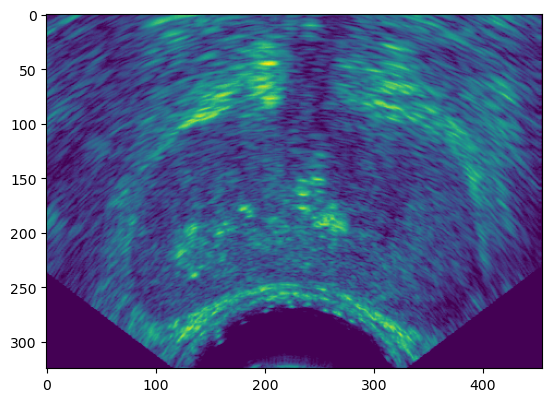

In [3]:
# Convert to a numpy array:

image_array = np.load(r"cw2_data.npy")

voxel_size_zyx = np.array([2.0, 0.2, 0.2])
z_voxel = voxel_size_zyx[0]
y_voxel = voxel_size_zyx[1]
x_voxel = voxel_size_zyx[2]

# Display an example axial image
plt.imshow(image_array[25, :, :])

0.7647058823529411 0.0


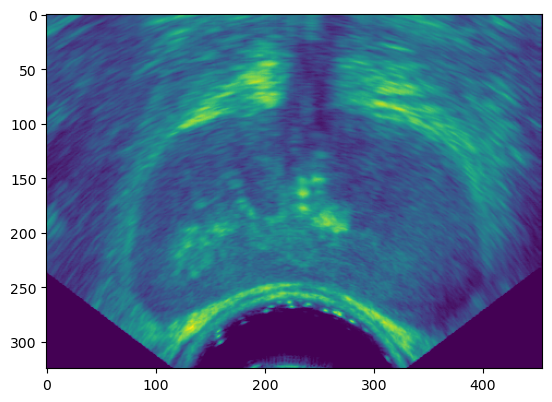

In [4]:
# Smooth the ultrasound images using a Gaussian filter to remove speckle noise, an inherent propety of this 
# modality. A 3 dimensional filter has been applied. Normalise pixel values between 0 and 1 before processing

normalised_image = image_array/255
print(np.max(normalised_image), np.min(normalised_image))

smoothed_image = sp.ndimage.gaussian_filter(normalised_image, sigma = ((z_voxel), (y_voxel), (x_voxel)))

plt.imshow(smoothed_image[25, :, :])

In [5]:
def image_derivatives_sobel(image):
    
    diff = np.array([[[1, 0, -1]]])
    diff_x = diff.reshape([1, 1, 3])
    diff_y = diff.reshape([1, 3, 1])
    diff_z = diff.reshape([3, 1, 1])

    G = np.array([[[1, 2, 1]]])
    G_x = G.reshape([1, 3, 1])
    G_y = G.reshape([1, 1, 3])
    G_z = G.reshape([3, 1, 1])

    deriv_x = sp.ndimage.convolve(image, diff_x)
    z_image_dx = sp.ndimage.convolve(deriv_x, G_z)
    y_image_dx = sp.ndimage.convolve(deriv_x, G_y)
   
    deriv_y = sp.ndimage.convolve(image, diff_y)
    x_image_dy = sp.ndimage.convolve(deriv_y, G_x)
    z_image_dy = sp.ndimage.convolve(deriv_y, G_z)
    
    deriv_z = sp.ndimage.convolve(image, diff_x)
    x_image_dz = sp.ndimage.convolve(deriv_z, G_x)
    y_image_dz = sp.ndimage.convolve(deriv_z, G_y)

    return  [z_image_dx, z_image_dy, y_image_dx, y_image_dz, x_image_dy, x_image_dz]

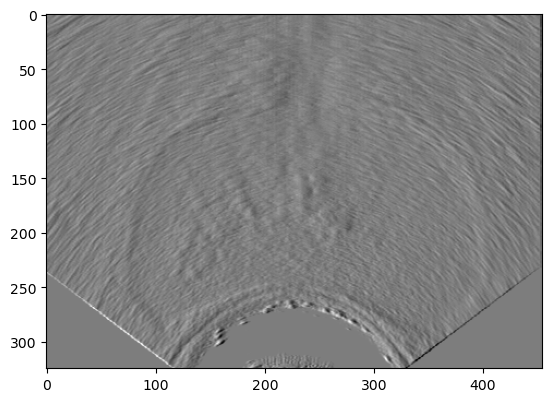

In [6]:
edge_image = image_derivatives_sobel(smoothed_image)
sobel_x = edge_image[0]
sobel_y = edge_image[1]

plt.imshow(sobel_x[25, :, :], cmap = "gray")

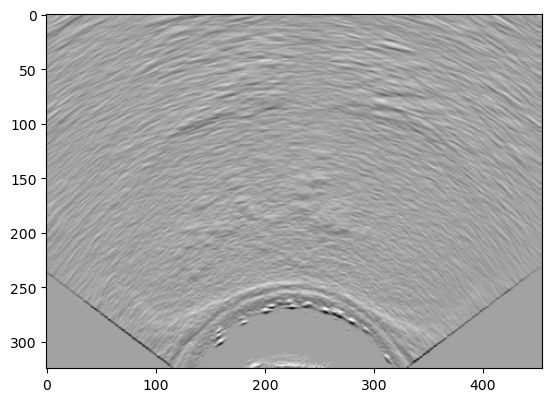

In [7]:
plt.imshow(sobel_y[25, :, :], cmap = "gray")

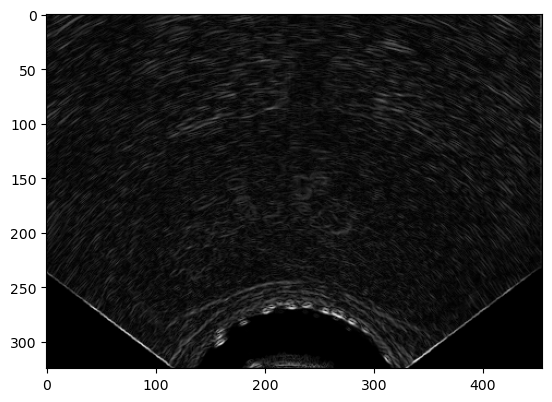

In [8]:
sobel_hypot = np.hypot(sobel_x, sobel_y)
plt.imshow(sobel_hypot[25, :, :], cmap = "gray")

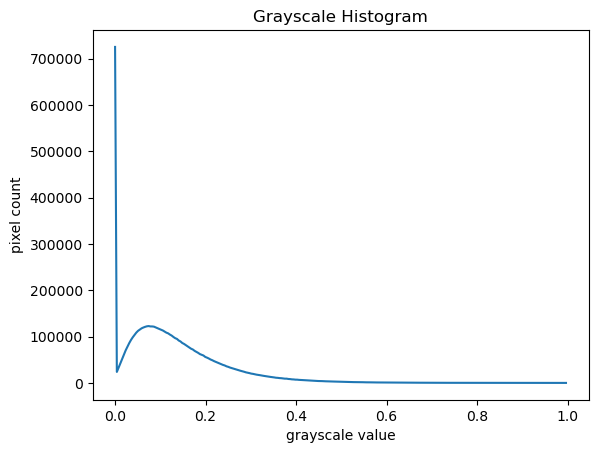

In [9]:
histogram, bin_edges = np.histogram(sobel_hypot, bins=256, range=(0.0, 1.0))
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")
plt.plot(bin_edges[0:-1], histogram)

In [10]:
# Failed attemptd to segment the prostate below

In [11]:
def segmentation (image, threshold):
    for index, x in np.ndenumerate(image):
        if x > threshold:
            x = 1
        else:
            x = 0
    return index, x

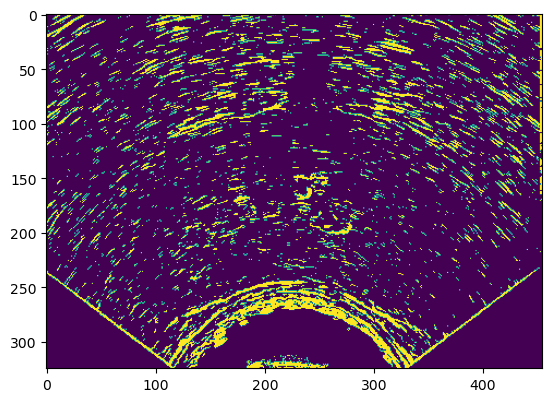

In [12]:
t = 0.25
binary_mask = sobel_hypot > t
plt.imshow(binary_mask[25, : ,:])

In [13]:
def segment(image, threshold):
    z = []
    y = []
    x = []
    for k in range (image.shape[0]):
        for i in range(image.shape[1]):
            for j in range(image.shape[2]):
                if image[k,i,j] > threshold:
                    z.append(1) # get z indices
                    y.append(1) # get y indices
                    x.append(1) # get x indices
    return z, y, x

In [14]:
def segment2(image, threshold):
    new_image = []
    for k in image:
        if k > threshold:
            new.image.append(1)
        else:
            new_image.append(0)
    return new_image.reshape(image)

In [15]:
test = segment(sobel_hypot, 0.2)

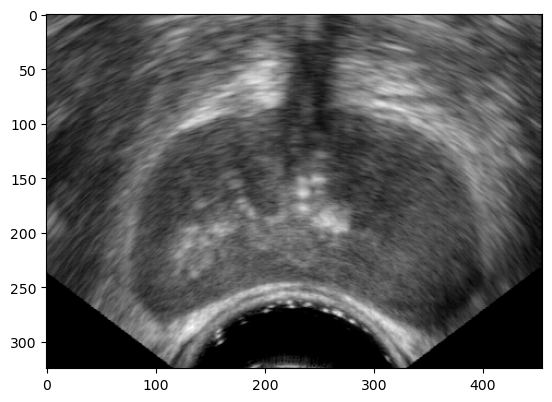

In [16]:
image_2D = smoothed_image[25,: :]
plt.imshow(image_2D, cmap = "gray")

length_z = (smoothed_image.shape[0])*(z_voxel)
length_y = (smoothed_image.shape[1])*(y_voxel)
length_x = (smoothed_image.shape[2])*(x_voxel)

# Create coordinate grid to assign pixel values (mm)
z_grid = np.arange(0, length_z, z_voxel)
y_grid = np.arange(0, length_y, y_voxel)
x_grid = np.arange(0, length_x, x_voxel)

Y, X = np.meshgrid([y_grid], [x_grid], indexing = "ij")
Z_3D, Y_3D, X_3D = np.meshgrid([z_grid], [y_grid], [x_grid], indexing = "ij")
coordinate_grid = np.transpose(np.array([Y, X]))
coordinate_grid_3D = np.transpose(np.array([Z_3D, Y_3D, X_3D]))
support_points = ([y_grid, x_grid])
support_points_3D = ([z_grid, y_grid, x_grid])

In [17]:
# From the displayed image, the section I would like to warp is y[100 - 150], x[175 - 325]

warp_y_grid = y_grid[99:149]
warp_x_grid = x_grid[174:324]

qy, qx = np.meshgrid([warp_y_grid], [warp_x_grid], indexing = "ij")

query_grid = coordinate_grid[174:324, 99:149]

In [18]:
def compute_ddf(query_points, qy, qx, transformation):

# Add a 1 to each coordinate to convert to homogeneous coordinates
        total_pixels = query_points.shape[0]*query_points.shape[1]
        ones = np.reshape(np.ones(total_pixels), (query_points.shape[0], query_points.shape[1]))
        coords = np.array([qx.flatten(), qy.flatten(), ones.flatten()])

# Perform transformation
        transform = transformation @ coords

# Reshape the transformed coordinates into a displacement field with the same shape as the original image
        ddf_ones = np.reshape(transform, coords.shape)

#Remove homogeneous coordinates
        ddf_flat = np.delete(ddf_ones,2,0)

# Reshape to size of original coordinate grid
        ddf = np.reshape(ddf_flat, query_points.shape)
        return ddf

In [19]:
expand = np.array([[1, 0, 0],
                   [0, 1.5, 0],
                   [0, 0, 1]])

warped_query = compute_ddf(query_grid, qy, qx, expand)

In [20]:
# Replace coordinates with warped coordinates
warped_coordinates = np.copy(coordinate_grid)
warped_coordinates[174:324, 99:149] = warped_query

In [21]:
def warp(support_points, image, new_coordinates):
    warp_grid = np.transpose(new_coordinates)
    interpolated_image = []
    for point in new_coordinates:
        int = sp.interpolate.interpn(support_points, image, point , method = "linear", bounds_error = False, fill_value = None)
        interpolated_image.append(int)
    return interpolated_image

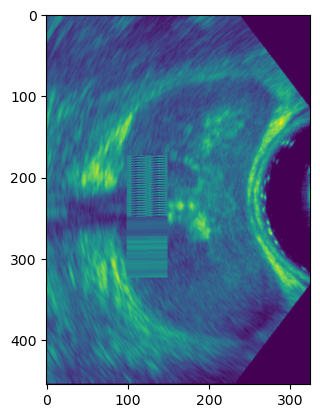

In [22]:
test = warp(support_points, image_2D, warped_coordinates)
plt.imshow(test)

In [23]:
# Unfortunately there is something wrong with my warp function so I have been unable to use this as my "source" 
# image. I will now apply a rigid transformation to the original 2d image (non-corrupted)

In [24]:
# ** Because the images are displayed in the format z, y, x, I have used the rotation matrix traditionally used 
# for "x" rotation to act on the z-coordinates, and the z-rotation matrix for x-axis rotation. 

def compute_transform(theta_z, theta_y, theta_x, T_z, T_y, T_x):
    translation = np.array([[1, 0, 0, T_z],
                            [0, 1, 0, T_y],
                            [0, 0, 1, T_x],
                            [0, 0, 0, 1]])
# Rotation around the z-axis
    Rot_Z = np.array([[1, 0, 0, 0],
                    [0, np.cos(theta_z), -np.sin(theta_z), 0],
                    [0, np.sin(theta_z), np.cos(theta_z), 0],
                    [0, 0, 0, 1]])

# Rotation around the y-axis
    Rot_Y = np.array([[np.cos(theta_y), 0, np.sin(theta_y), 0],
                    [0, 1 , 0, 0],
                    [-np.sin(theta_y), 0, np.cos(theta_y), 0],
                    [0, 0, 0, 1]])

# Rotation around the x-axis
    Rot_X = np.array([[np.cos(theta_x), -np.sin(theta_x), 0, 0],
                    [np.sin(theta_x), np.cos(theta_x) , 0, 0],
                    [0, 0 , 1, 0],
                    [0, 0, 0, 1]])
        
    transformation = Rot_Z @ Rot_Y @ Rot_X @ translation
    return transformation


In [36]:
def image_ddf(image, transformation, Z, Y, X, coordinate_grid_3D):

# Add a 1 to each coordinate to convert to homogeneous
    total_pixels = image.shape[0]*image.shape[1]*image.shape[2]
    ones = np.reshape(np.ones(total_pixels), (image.shape[0], image.shape[1], image.shape[2]))
    coords = np.array([Z.flatten(), Y.flatten(), X.flatten(), ones.flatten()])

# Perform transformation
    transform = transformation @ coords

# Reshape the transformed coordinates into a displacement field with the same shape as the original image
    ddf_ones = np.reshape(transform, coords.shape)

#Remove homogeneous coordinates
    ddf_flat = np.delete(ddf_ones,3,0)

# Reshape to size of original coordinate grid
    ddf = np.reshape(ddf_flat, coordinate_grid_3D.shape)
    return ddf

def warp_image(support_points, image, ddf):
    warp_grid = ddf
    interpolated_image = []
    for point in warp_grid:
        int = sp.interpolate.interpn(support_points, image, point, method = "linear", bounds_error = False, fill_value = 0)
        interpolated_image.append(int)
    return np.transpose(interpolated_image)

In [37]:
transform_coordinates = compute_transform(np.pi/6, np.pi/12, np.pi/12, 2, 3, 2)

In [38]:
rigid_ddf = image_ddf(smoothed_image, transform_coordinates, Z_3D, Y_3D, X_3D, coordinate_grid_3D)

In [43]:
transformed_image = warp_image(support_points_3D, smoothed_image, rigid_ddf)

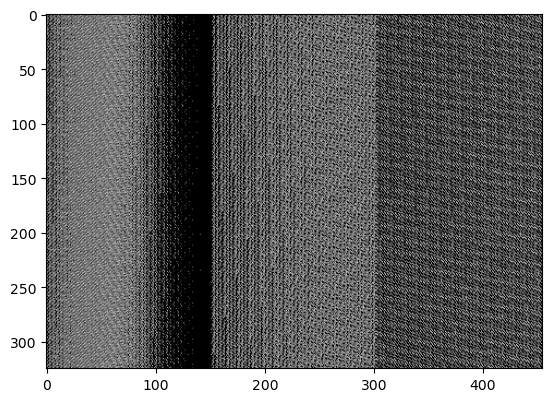

In [44]:
plt.imshow(transformed_image[25,:,:], cmap = "gray")